# Groceries E-commerce EDA


In [78]:
# Imports and constants

import os
import boto3
from dotenv import load_dotenv
import pathlib
import pandas as pd
import fastparquet as fp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
from typing import Optional, Tuple, List, Dict, Any
import calendar
from itertools import chain
from collections import Counter


# Load environment variables from .env file
load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
S3_PATH = "s3://zrive-ds-data/groceries/sampled-datasets/"
LOCAL_DATA_PATH = 'groceries_data/'


## 1. Download or get data

First time we need to download the data from AWS s3://zrive-ds-data/groceries/sampled-datasets/ and save it. Next times, we only need to access local data. 

In [2]:
def download_grocery_data(aws_url: str, local_path: str) -> None:
    """
    Downloads all grocery data files (.parquet) from s3 dir and saves them to the specified local path.
    """

    print(f"Downloading grocery data from {aws_url} to {local_path}")
    
    # Create local directory if it doesn't exist
    pathlib.Path(local_path).mkdir(parents=True, exist_ok=True)

    # Initialize S3 client
    s3 = boto3.client(
        's3',
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

    # Extract bucket name and prefix from the S3 path
    bucket_name = aws_url.split('/')[2]
    prefix = '/'.join(aws_url.split('/')[3:])
    print(f"Bucket_name: {bucket_name}, Prefix: {prefix}")

    # List objects in the specified S3 bucket and prefix
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
    if 'Contents' not in response:
        print("No contents found in the specified S3 path.")
        return
    for obj in response['Contents']:
        file_key = obj['Key']
        file_name = os.path.basename(file_key)
        local_file_path = os.path.join(local_path, file_name)

        # Download the file
        print(f"Downloading {file_key} to {local_file_path}")
        s3.download_file(bucket_name, file_key, local_file_path)



def data_file_exists(local_path: str, filename: str) -> bool:
    """
    Check if the specified file exists in the local directory.
    """
    file_path = os.path.join(local_path, filename)
    return os.path.isfile(file_path)


def get_grocery_file(file: str = 'orders.parquet') -> pd.DataFrame:
    """
    Main function to get grocery file. Downloads all the data if file doesn't exist locally.
    """
    # Check if the file exists locally
    if not data_file_exists(LOCAL_DATA_PATH, file):
        # If the file doesn't exist, download all grocery data
        download_grocery_data(S3_PATH, LOCAL_DATA_PATH)
    else:
        print(f"File {file} already exists locally. Skipping download.")
    # Read the parquet file into a DataFrame
    file_path = os.path.join(LOCAL_DATA_PATH, file)
    print(f"Reading {file_path} into DataFrame")
    orders_df = pd.read_parquet(file_path, engine='fastparquet')
    
    return orders_df

Get all parquet files and convert to DataFrames

In [105]:
orders_df = get_grocery_file('orders.parquet')
regulars_df = get_grocery_file('regulars.parquet')
abandoned_carts_df = get_grocery_file('abandoned_carts.parquet')
inventory_df = get_grocery_file('inventory.parquet')
users_df = get_grocery_file('users.parquet')

File orders.parquet already exists locally. Skipping download.
Reading groceries_data/orders.parquet into DataFrame
File regulars.parquet already exists locally. Skipping download.
Reading groceries_data/regulars.parquet into DataFrame
File abandoned_carts.parquet already exists locally. Skipping download.
Reading groceries_data/abandoned_carts.parquet into DataFrame
File inventory.parquet already exists locally. Skipping download.
Reading groceries_data/inventory.parquet into DataFrame
File users.parquet already exists locally. Skipping download.
Reading groceries_data/users.parquet into DataFrame


In [ ]:
def plot_dist_and_boxplot(df: pd.DataFrame, column: str, title: str, xlabel: str) -> None:
    """
    Plot distribution and boxplot for a given column in the DataFrame.
    """
    plt.figure(figsize=(10, 5))
    plt.hist(df[column], bins=50, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {title}')
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Orders DataFrame

In [82]:
orders_df

,id,user_id,created_at,order_date,user_order_seq,ordered_items,order_day,order_month,items_num,num_items
10,2204073066628,62e271062eb827e411bd73941178d29b022f5f2de9d37f...,2020-04-30 14:32:19,2020-04-30,1,"[33618849693828, 33618860179588, 3361887404045...",2020-04-30,2020-04,14,14
20,2204707520644,bf591c887c46d5d3513142b6a855dd7ffb9cc00697f6f5...,2020-04-30 17:39:00,2020-04-30,1,"[33618835243140, 33618835964036, 3361886244058...",2020-04-30,2020-04,25,25
21,2204838822020,329f08c66abb51f8c0b8a9526670da2d94c0c6eef06700...,2020-04-30 18:12:30,2020-04-30,1,"[33618891145348, 33618893570180, 3361889766618...",2020-04-30,2020-04,15,15
34,2208967852164,f6451fce7b1c58d0effbe37fcb4e67b718193562766470...,2020-05-01 19:44:11,2020-05-01,1,"[33618830196868, 33618846580868, 3361891234624...",2020-05-01,2020-05,10,10
49,2215889436804,68e872ff888303bff58ec56a3a986f77ddebdbe5c279e7...,2020-05-03 21:56:14,2020-05-03,1,"[33667166699652, 33667166699652, 3366717122163...",2020-05-03,2020-05,10,10
...,...,...,...,...,...,...,...,...,...,...
64396,4026096910468,f524eaf26b76bc6226747768f120ffcd23d5c3d52a0a19...,2022-03-13 10:14:22,2022-03-13,5,"[33981947707524, 34284951273604, 3428495127360...",2022-03-13,2022-03,17,17
64488,4026464993412,aa5e21db3186dcd84c161719c5ade8a19adb853ea8bfef...,2022-03-13 18:30:31,2022-03-13,3,"[33803540725892, 34284950519940, 3437091504141...",2022-03-13,2022-03,9,9
64499,4026553434244,14be3833c19e0a1fd7e6db0e5375a3d1dcc9efafcb0e69...,2022-03-13 20:11:50,2022-03-13,11,"[39283356663940, 39283356663940, 4015514504410...",2022-03-13,2022-03,4,4
64523,4026656030852,500027bf392bfa9ef527919569fba44904d429155b7cf4...,2022-03-13 22:29:24,2022-03-13,4,"[33824368033924, 33824368033924, 3382436803392...",2022-03-13,2022-03,4,4


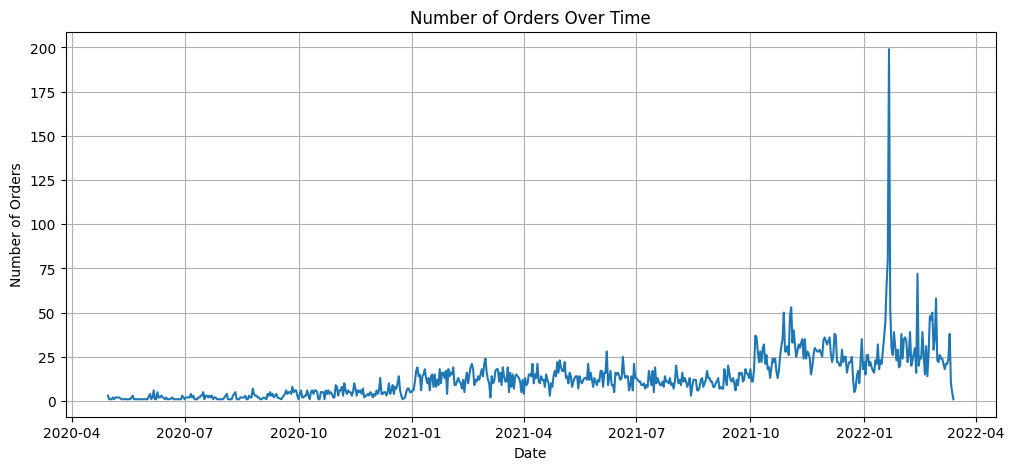

In [28]:
orders_per_day = orders_df.groupby('order_day').size()

plt.figure(figsize=(12, 5))
plt.plot(orders_per_day.index, orders_per_day.values)
plt.title('Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.show()

In [39]:
# Day with the most orders
most_orders_day = orders_per_day.idxmax()
most_orders_count = orders_per_day.max()
print(f"Day with the most orders: {most_orders_day} with {most_orders_count} orders")

Day with the most orders: 2022-01-21 with 199 orders


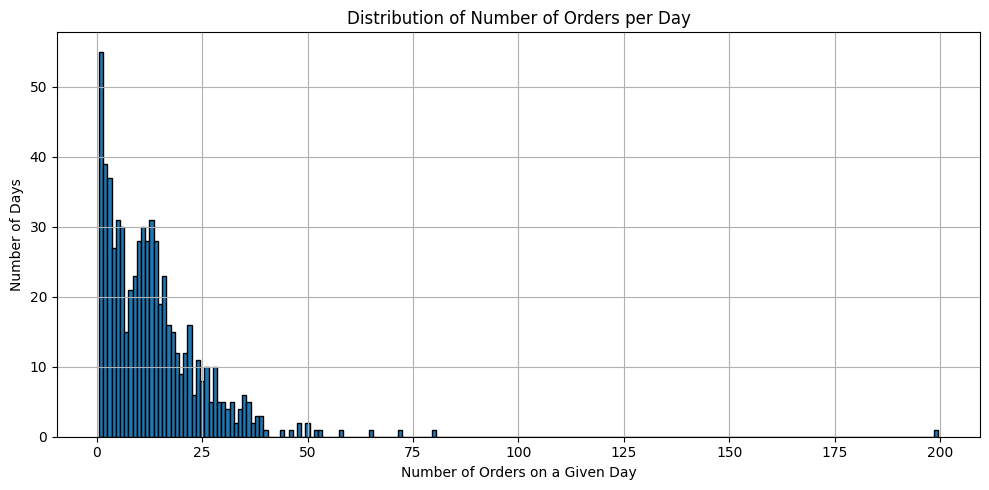

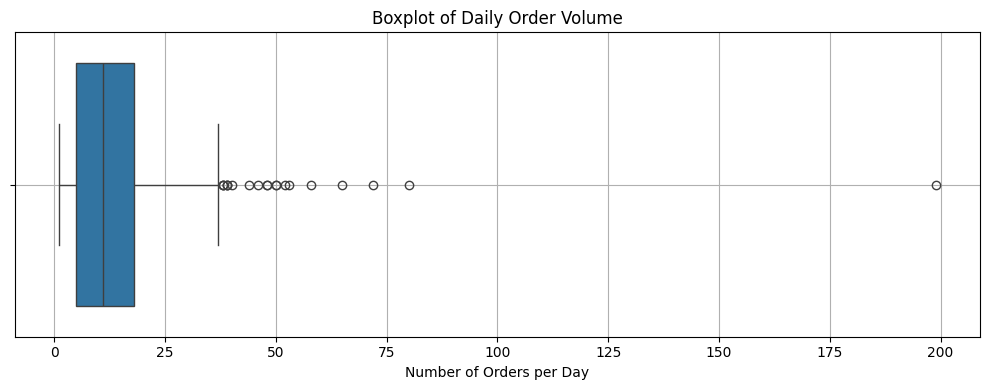

In [ ]:
# Plot histogram of number of orders per day
plt.figure(figsize=(10, 5))
plt.hist(orders_per_day.values, bins=range(1, orders_per_day.max() + 2), edgecolor='black', align='left')
plt.title('Distribution of Number of Orders per Day')
plt.xlabel('Number of Orders on a Given Day')
plt.ylabel('Number of Days')
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of number of orders per day
plt.figure(figsize=(10, 4))
sns.boxplot(x=orders_per_day.values)
plt.title('Boxplot of Daily Order Volume')
plt.xlabel('Number of Orders per Day')
plt.grid(True)
plt.tight_layout()
plt.show()

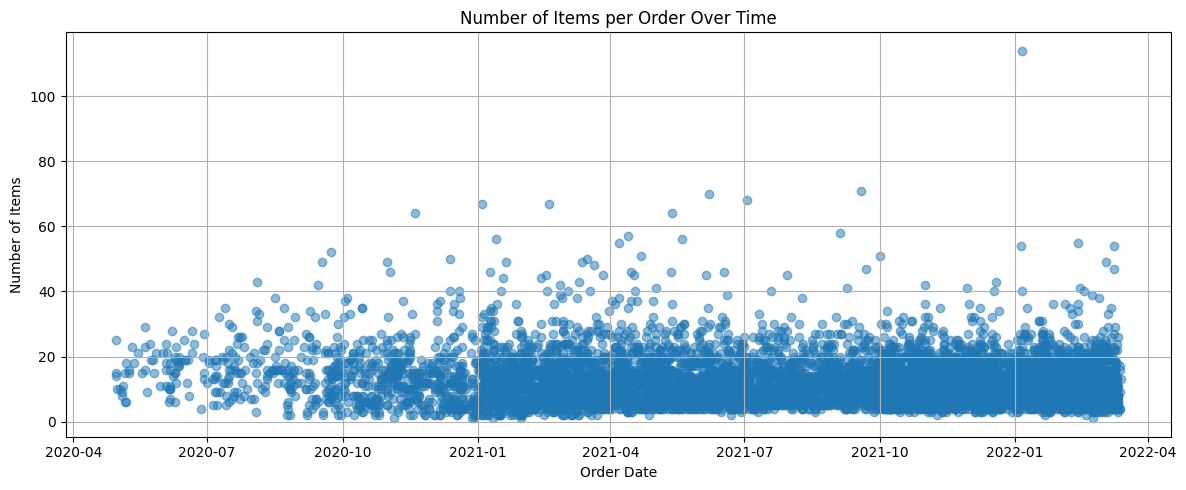

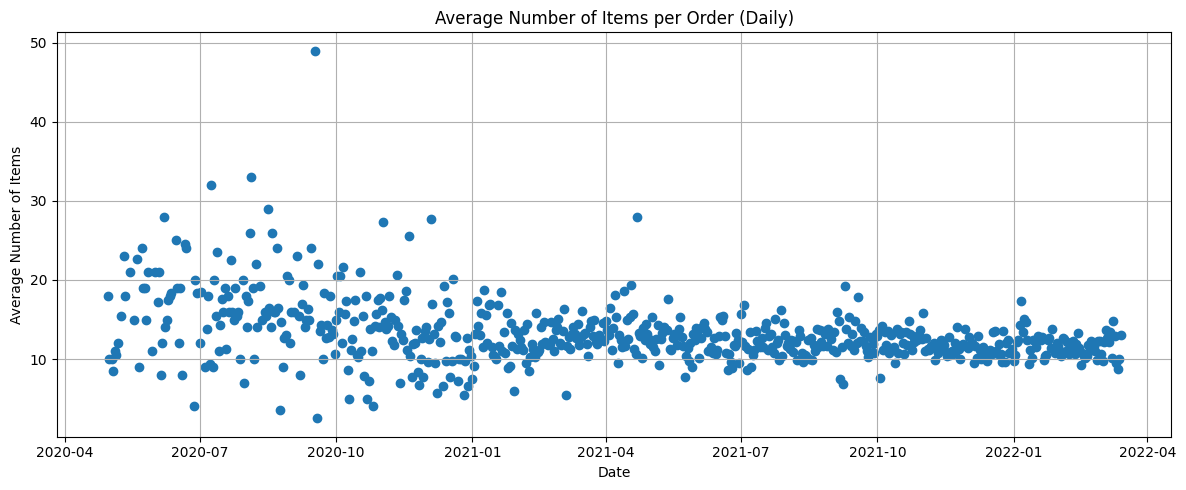

In [55]:
# Scatter plot: items per order over time
plt.figure(figsize=(12, 5))
plt.scatter(orders_df['order_date'], orders_df['num_items'], alpha=0.5)
plt.title('Number of Items per Order Over Time')
plt.xlabel('Order Date')
plt.ylabel('Number of Items')
plt.grid(True)
plt.tight_layout()
plt.show()

# Average number of items per day
avg_items_per_day = orders_df.groupby(orders_df['order_date'].dt.date)['num_items'].mean()

plt.figure(figsize=(12, 5))
plt.scatter(avg_items_per_day.index, avg_items_per_day.values, marker='o')
plt.title('Average Number of Items per Order (Daily)')
plt.xlabel('Date')
plt.ylabel('Average Number of Items')
plt.grid(True)
plt.tight_layout()
plt.show()


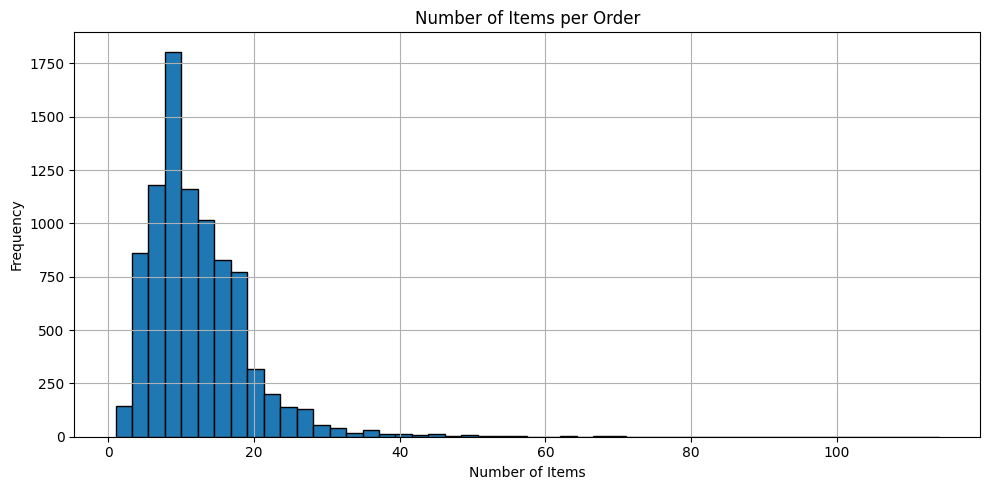

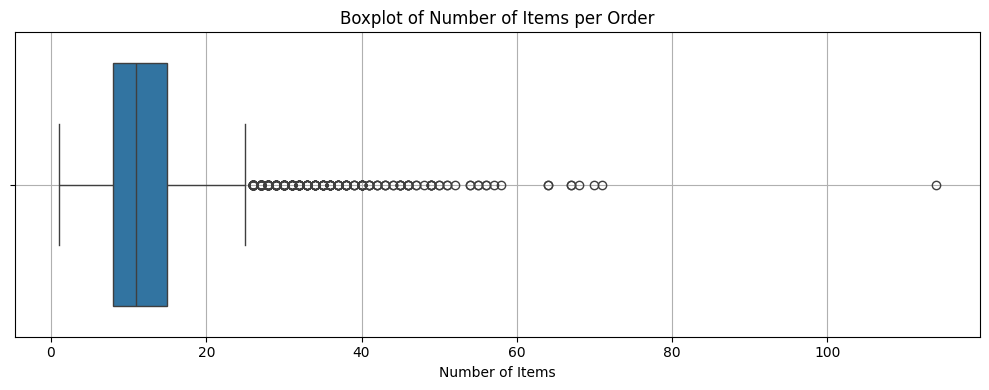

In [177]:
orders_df['num_items'] = orders_df['ordered_items'].apply(len)

plot_dist_and_boxplot(orders_df, 'num_items', 'Number of Items per Order', 'Number of Items')

In [53]:
# Day with the order with the most items
most_items_day = orders_df.loc[orders_df['num_items'].idxmax(), 'order_date']
most_items_count = orders_df['num_items'].max()
print(f"Day with the most items in an order: {most_items_day} with {most_items_count} items")

Day with the most items in an order: 2022-01-06 00:00:00 with 114 items


I'm going to save all items seen in ordered_items for future analysis

In [74]:
all_ordered_items = list(chain.from_iterable(orders_df['ordered_items']))
ordered_item_ids = set(all_ordered_items)

### Regulars DataFrame

In [166]:
regulars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 565.8+ KB


### Abandoned Carts DataFrame

In [167]:
abandoned_carts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[ns]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 213.2+ KB


### Inventory DataFrame

In [56]:
inventory_df.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


Here we should find all the items, so all the ordered items should appear here. Let's see

In [77]:
inventory_item_ids = set(inventory_df['variant_id'])
missing_item_ids = ordered_item_ids - inventory_item_ids
print(f"Missing items: {len(missing_item_ids)} ({len(missing_item_ids) / len(ordered_item_ids) * 100:.2f}%)")

Missing items: 640 (30.23%)


Oh, there are 640 items ordered without information in inventory

Now let's see other columns

In [191]:
vendor_description = inventory_df['vendor'].describe()
product_type_description = inventory_df['product_type'].describe()

print("Vendor Description:")
print(vendor_description)
print("\nProduct Type Description:")
print(product_type_description)
plt.show()

Vendor Description:
count      1733
unique      412
top       biona
freq         69
Name: vendor, dtype: object

Product Type Description:
count                  1733
unique                   59
top       cleaning-products
freq                    160
Name: product_type, dtype: object


Number of unique tags: 214


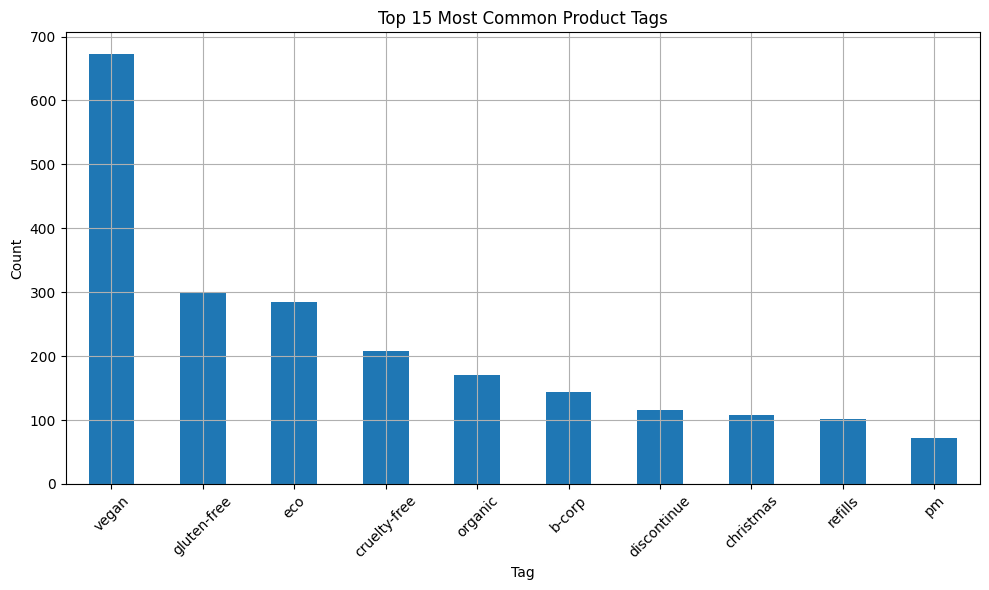

In [148]:
all_tags = inventory_df['tags'].explode()
unique_tags = all_tags.nunique()
print(f"Number of unique tags: {unique_tags}")

tag_counts = all_tags.value_counts()
top_tags = tag_counts.head(10)

plt.figure(figsize=(10, 6))
top_tags.plot(kind='bar')
plt.title('Top 10 Most Common Product Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

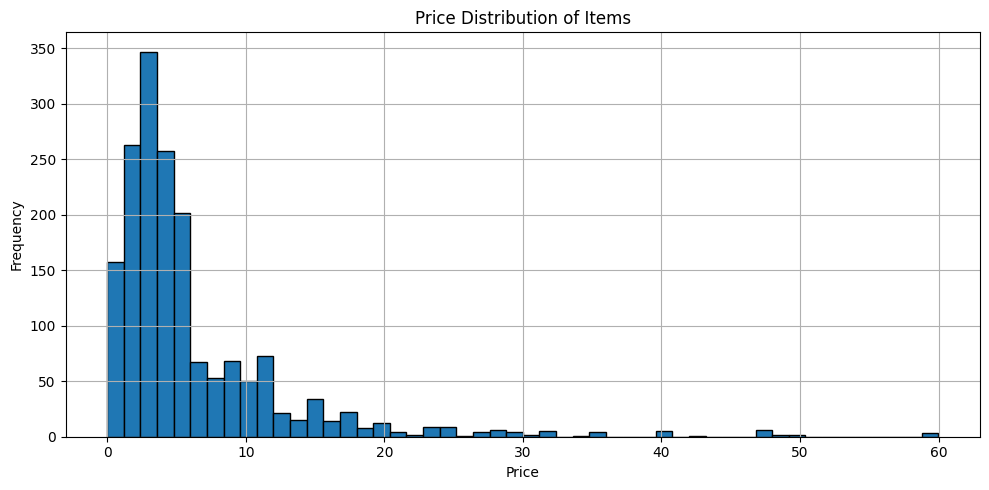

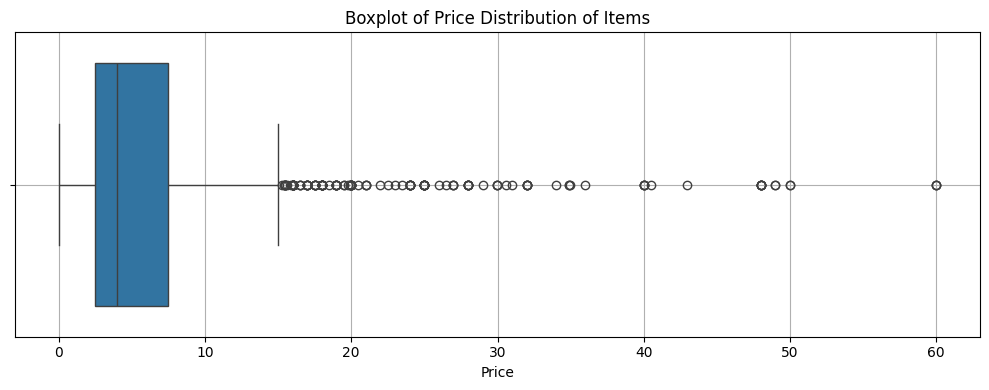

In [178]:
plot_dist_and_boxplot(inventory_df, 'price', 'Price Distribution of Items', 'Price')


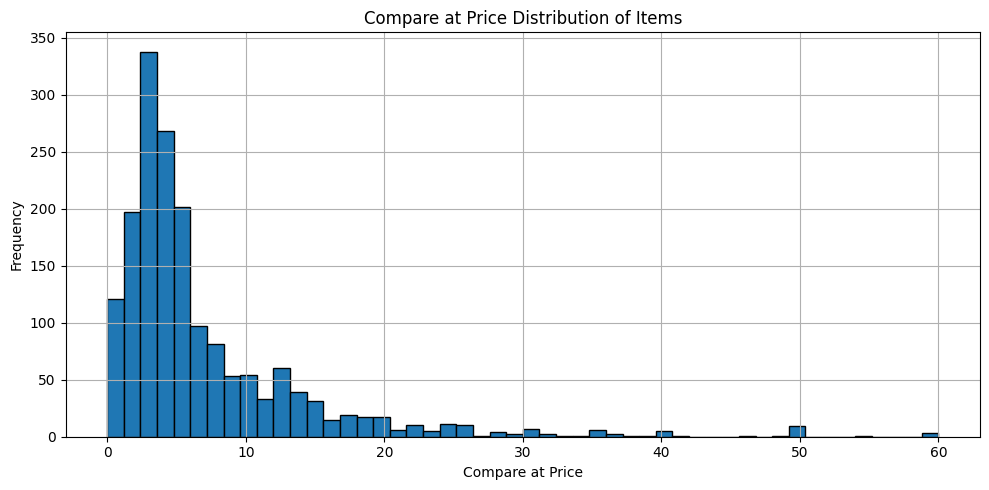

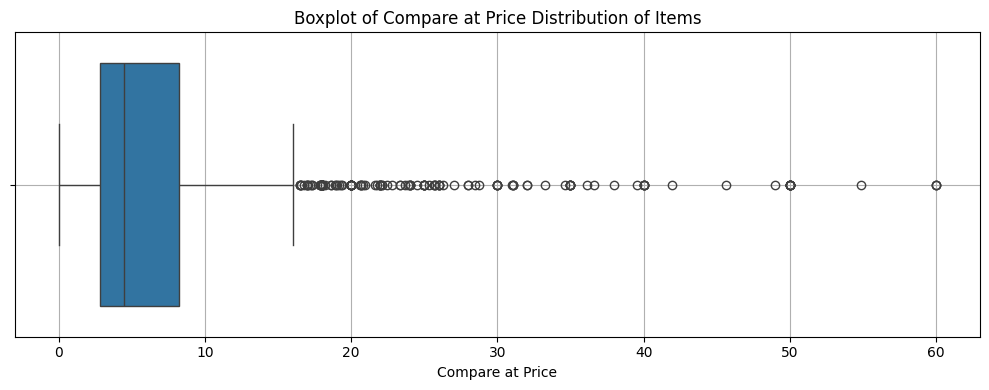

In [179]:
plot_dist_and_boxplot(inventory_df, 'compare_at_price', 'Compare at Price Distribution of Items', 'Compare at Price')

No much idea about what is compare_at_price, but seems that always is a bit higher than "price". Could be the original price to show when there is a promotion.  

Then: price_at_compare -> After: price

Let's add a discount column

In [204]:
inventory_df['discount_percent'] = ((inventory_df['compare_at_price'] - inventory_df['price']) / inventory_df['compare_at_price']) * 100

inventory_df[inventory_df['discount_percent'].isna()]

,variant_id,price,compare_at_price,vendor,product_type,tags,dif_price,discount_percent
95,40070658490500,0.0,0.0,jordans,cereal,[cereal-bars],0.0,NaN
96,40167931674756,0.0,0.0,whogivesacrap,,[],0.0,NaN
97,40167931707524,0.0,0.0,whogivesacrap,,[],0.0,NaN
99,40070656786564,0.0,0.0,mcvities,biscuits-crackers,"[biscuits, pm]",0.0,NaN
100,40070657933444,0.0,0.0,astonish,cleaning-products,[bathroom-limescale-cleaner],0.0,NaN
...,...,...,...,...,...,...,...,...
1554,40070660292740,0.0,0.0,biona,biscuits-crackers,[crackers],0.0,NaN
1575,40070658654340,0.0,0.0,lovecorn,snacks-confectionery,[savoury-snacks],0.0,NaN
1623,40070660587652,0.0,0.0,snackajack,biscuits-crackers,[crackers],0.0,NaN
1627,40070660489348,0.0,0.0,garnier,skincare,[facial-skincare],0.0,NaN


Vendor and Product Type quick analysis

### Users DataFrame

In [88]:
print(f"Shape of users_df: {users_df.shape}")
users_df.head()

Shape of users_df: (4983, 10)


,user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets
2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a...,Top Up,UKH,2021-05-08 13:33:49,2021-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f...,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN
1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b9324...,Top Up,UKD,2022-03-09 23:12:25,2022-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN
675,57ca7591dc79825df0cecc4836a58e6062454555c86c35...,Top Up,UKI,2021-04-23 16:29:02,2021-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN
4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec00...,Top Up,UKJ,2021-11-02 13:50:06,2021-11-01 00:00:00,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'User Segments')

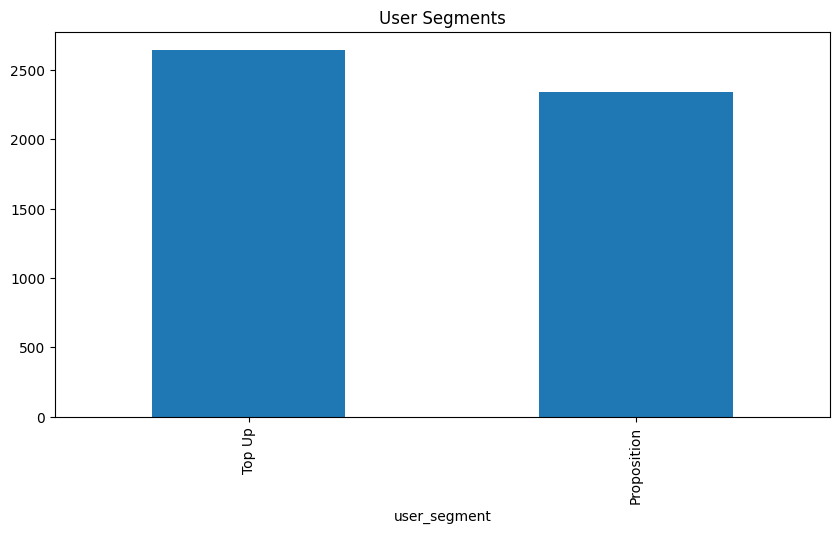

In [95]:
users_df['user_segment'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('User Segments')

Text(0.5, 1.0, 'User NUTS1 Regions')

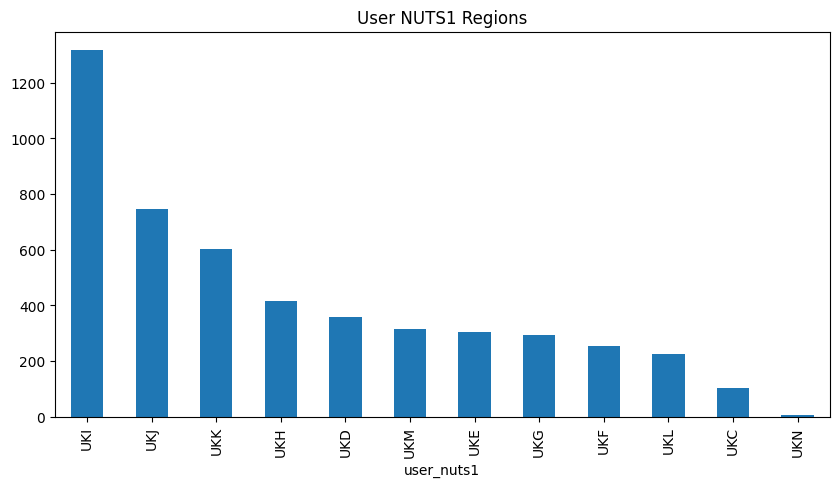

In [96]:
users_df['user_nuts1'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('User NUTS1 Regions')

In [129]:
columns = ['count_people', 'count_adults', 'count_children', 'count_babies', 'count_pets']

nan_stats = pd.DataFrame({
    'missing_count': users_df[columns].isna().sum(),
    'total_rows': len(users_df),
})

nan_stats['missing_percent'] = (nan_stats['missing_count'] / nan_stats['total_rows']) * 100
nan_stats = nan_stats.drop(columns='total_rows')  # optional

print(nan_stats)


                missing_count  missing_percent
count_people             4658        93.477825
count_adults             4658        93.477825
count_children           4658        93.477825
count_babies             4658        93.477825
count_pets               4658        93.477825


We can see the percent of nan values in each column is the same. So, if any user has a NaN value in one column, this means that this user hasn´t any value? And, if some user has a value in some of these columns, this means that it has taken all values? Let's see it

Text(0.5, 1.0, 'Count of Users by Number of NaNs in Group Columns')

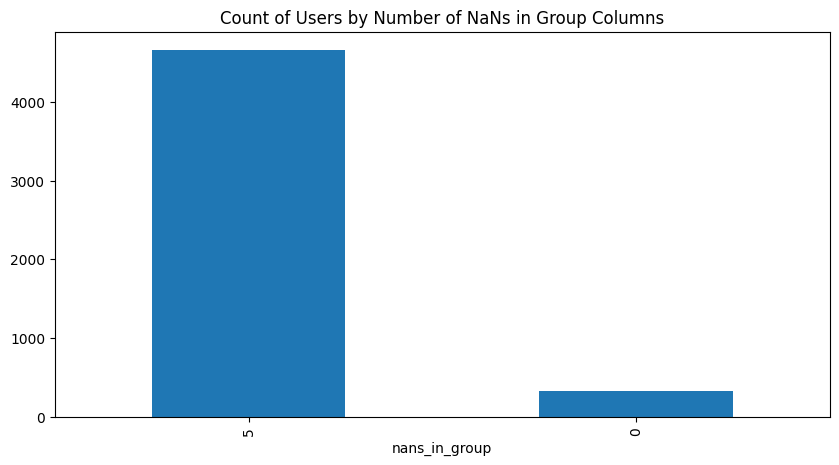

In [125]:
# For each user, count the number of NaN values in the specified columns
users_df['nans_in_group'] = users_df[columns].isna().sum(axis=1)

users_df['nans_in_group'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Count of Users by Number of NaNs in Group Columns')


Yes!! We can conclude that are users with all the columns with NaN, and are users with all the columns with correct values. But there aren´t users with parcialy filled data

So, what we should do with NaN values? Impute this group columns is dangerous, because the 93% of users have NaN values. Remove this data should be an option.

## Análisis de los items y variants

In [ ]:
# Comparemos los IDs en ordered_items con los variant_id en inventory
inventory_ids = set(inventory_df['variant_id'].unique())
print(f"\nNúmero de variant_ids únicos en inventory: {len(inventory_ids)}")

order_items_set = set(all_ordered_items)
print(f"Número de items únicos en ordered_items: {len(order_items_set)}")

# Veamos cuántos items de las órdenes no están en el inventario
missing_items = order_items_set - inventory_ids
print(f"Número de items que no están en inventory: {len(missing_items)}")
print(f"Ejemplos de items faltantes: {list(missing_items)[:5]}")


Número de variant_ids únicos en inventory: 1733
Número de items únicos en ordered_items: 2117
Número de items que no están en inventory: 640
Ejemplos de items faltantes: [33826455650436, 34529808777348, 34490663338116, 33667222896772, 33667300491396]


## Orders a lo largo del tiempo

Timeline de número de orders, agrupado por més

In [193]:
# Configuramos el estilo de las visualizaciones
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_orders_time_series(
    orders_df: pd.DataFrame,
    date_column: str = 'order_date',
    aggregation: str = 'monthly',
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    rolling_window: Optional[int] = None,
    show_trend: bool = True,
    show_weekday_chart: bool = False,
    show_summary_stats: bool = True,
    figsize: Tuple[int, int] = (14, 8),
    title_prefix: str = 'Evolución de Pedidos',
    color: str = '#1f77b4',
    trend_color: str = 'red',
    save_fig: bool = False,
    filename: str = 'orders_time_series.png'
) -> Dict[str, Any]:
    """
    Visualiza la evolución temporal de pedidos con múltiples opciones de configuración.
    
    Parameters:
    -----------
    orders_df : pd.DataFrame
        DataFrame que contiene los datos de pedidos
    date_column : str
        Nombre de la columna con las fechas de los pedidos
    aggregation : str
        Nivel de agregación temporal ('daily', 'weekly', 'monthly', 'quarterly', 'yearly')
    start_date : str, opcional
        Fecha de inicio para filtrar (formato: 'YYYY-MM-DD')
    end_date : str, opcional
        Fecha final para filtrar (formato: 'YYYY-MM-DD')
    rolling_window : int, opcional
        Tamaño de la ventana para la media móvil
    show_trend : bool
        Si se muestra la línea de tendencia
    show_weekday_chart : bool
        Si se muestra el gráfico adicional de patrones por día de la semana
    show_summary_stats : bool
        Si se muestran estadísticas resumen
    figsize : tuple
        Tamaño de la figura
    title_prefix : str
        Prefijo para el título del gráfico
    color : str
        Color principal para la línea del gráfico
    trend_color : str
        Color para la línea de tendencia
    save_fig : bool
        Si se guarda la figura en un archivo
    filename : str
        Nombre del archivo para guardar la figura
        
    Returns:
    --------
    Dict[str, Any]
        Diccionario con estadísticas y datos del análisis
    """
    # Copia del DataFrame para no modificar el original
    df = orders_df.copy()
    
    # Aseguramos que la columna de fecha sea datetime
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Filtrar por rango de fechas si se especifica
    if start_date:
        start_date = pd.to_datetime(start_date)
        df = df[df[date_column] >= start_date]
    
    if end_date:
        end_date = pd.to_datetime(end_date)
        df = df[df[date_column] <= end_date]
    
    # Verificar si hay datos después del filtrado
    if len(df) == 0:
        print("No hay datos disponibles para el rango de fechas especificado.")
        return {}
    
    # Configurar la agregación temporal
    aggregation_mapping = {
        'daily': 'D',
        'weekly': 'W',
        'monthly': 'M',
        'quarterly': 'Q',
        'yearly': 'Y'
    }
    
    freq = aggregation_mapping.get(aggregation.lower(), 'M')
    
    # Crear columna de periodo según agregación
    if freq == 'D':
        df['period'] = df[date_column]
        date_format = '%d %b %Y'
        x_label = 'Fecha'
        title_suffix = 'Diarios'
        locator = mdates.AutoDateLocator()
    elif freq == 'W':
        df['period'] = df[date_column].dt.to_period('W').dt.to_timestamp()
        date_format = '%d %b %Y'
        x_label = 'Semana'
        title_suffix = 'Semanales'
        locator = mdates.WeekdayLocator(interval=1)
    elif freq == 'M':
        df['period'] = df[date_column].dt.to_period('M').dt.to_timestamp()
        date_format = '%b %Y'
        x_label = 'Mes'
        title_suffix = 'Mensuales'
        locator = mdates.MonthLocator(interval=1)
    elif freq == 'Q':
        df['period'] = df[date_column].dt.to_period('Q').dt.to_timestamp()
        date_format = 'Q%q %Y'
        x_label = 'Trimestre'
        title_suffix = 'Trimestrales'
        locator = mdates.MonthLocator(interval=3)
    else:  # yearly
        df['period'] = df[date_column].dt.to_period('Y').dt.to_timestamp()
        date_format = '%Y'
        x_label = 'Año'
        title_suffix = 'Anuales'
        locator = mdates.YearLocator()
    
    # Contar pedidos por periodo
    period_counts = df.groupby('period').size().reset_index(name='count')
    
    # Crear la gráfica
    fig, ax = plt.subplots(figsize=figsize)
    
    # Gráfico de línea con marcadores si no hay muchos puntos
    use_markers = len(period_counts) <= 30
    
    if use_markers:
        sns.lineplot(
            data=period_counts, 
            x='period', 
            y='count',
            marker='o',
            markersize=8,
            linewidth=2,
            color=color,
            ax=ax
        )
    else:
        sns.lineplot(
            data=period_counts, 
            x='period', 
            y='count',
            linewidth=2,
            color=color,
            ax=ax
        )
    
    # Añadir línea de tendencia (media móvil)
    if show_trend and len(period_counts) > 2:
        # Determinar el tamaño de la ventana automáticamente si no se especifica
        if rolling_window is None:
            # Utilizamos un 20% de los datos como ventana, mínimo 2
            rolling_window = max(2, int(len(period_counts) * 0.2))
        
        if len(period_counts) > rolling_window:
            period_counts['rolling_avg'] = period_counts['count'].rolling(
                window=rolling_window, center=True).mean()
            
            sns.lineplot(
                data=period_counts, 
                x='period', 
                y='rolling_avg',
                linewidth=2.5,
                color=trend_color,
                label=f'Media móvil ({rolling_window} periodos)',
                ax=ax
            )
            plt.legend()
    
    # Configurar el formato del eje X
    ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))
    ax.xaxis.set_major_locator(locator)
    
    # Rotamos las etiquetas para mejor legibilidad
    plt.xticks(rotation=45, ha='right')
    
    # Ajustar el eje Y
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(bottom=0)
    
    # Añadir etiquetas de valores si no hay muchos puntos
    if len(period_counts) <= 15:
        for i, row in period_counts.iterrows():
            ax.text(row['period'], row['count'] + max(period_counts['count'])*0.02, 
                    f"{row['count']}", 
                    ha='center', va='bottom', fontsize=10)
    
    # Añadir título y etiquetas
    plt.title(f'{title_prefix} {title_suffix}', fontsize=16, pad=20)
    plt.xlabel(x_label, fontsize=14, labelpad=10)
    plt.ylabel('Número de Pedidos', fontsize=14, labelpad=10)
    
    # Ajustar márgenes
    plt.tight_layout()
    
    # Guardar figura si se solicita
    if save_fig:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # Mostrar gráfica
    plt.show()
    
    # Calcular estadísticas básicas
    stats = {
        'total_orders': period_counts['count'].sum(),
        'avg_orders_per_period': period_counts['count'].mean(),
        'max_orders': period_counts['count'].max(),
        'min_orders': period_counts['count'].min(),
        'max_period': period_counts.loc[period_counts['count'].idxmax(), 'period'],
        'min_period': period_counts.loc[period_counts['count'].idxmin(), 'period'],
    }
    
    # Mostrar estadísticas si se solicita
    if show_summary_stats:
        print(f"Total de pedidos: {stats['total_orders']}")
        print(f"Promedio por {aggregation[:-2] if aggregation.endswith('ly') else aggregation}: {stats['avg_orders_per_period']:.1f} pedidos")
        
        # Formato de fecha según la agregación
        if freq == 'D':
            max_date_str = stats['max_period'].strftime('%d-%m-%Y')
            min_date_str = stats['min_period'].strftime('%d-%m-%Y')
        elif freq == 'W':
            max_date_str = f"Semana del {stats['max_period'].strftime('%d-%m-%Y')}"
            min_date_str = f"Semana del {stats['min_period'].strftime('%d-%m-%Y')}"
        elif freq == 'M':
            max_date_str = stats['max_period'].strftime('%b %Y')
            min_date_str = stats['min_period'].strftime('%b %Y')
        elif freq == 'Q':
            max_date_str = f"Q{(stats['max_period'].month-1)//3+1} {stats['max_period'].year}"
            min_date_str = f"Q{(stats['min_period'].month-1)//3+1} {stats['min_period'].year}"
        else:  # yearly
            max_date_str = str(stats['max_period'].year)
            min_date_str = str(stats['min_period'].year)
            
        print(f"Periodo con más pedidos: {max_date_str} ({stats['max_orders']} pedidos)")
        print(f"Periodo con menos pedidos: {min_date_str} ({stats['min_orders']} pedidos)")
    
    # Análisis de patrones por día de la semana (opcional)
    if show_weekday_chart and len(df) > 0:
        df['day_of_week'] = df[date_column].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        
        plt.figure(figsize=(12, 6))
        weekday_pattern = df.groupby('day_of_week').size().reset_index(name='count')
        
        # Ordenar los días correctamente
        weekday_pattern['day_of_week'] = pd.Categorical(
            weekday_pattern['day_of_week'], 
            categories=day_order, 
            ordered=True
        )
        weekday_pattern = weekday_pattern.sort_values('day_of_week')
        
        # Calcular el promedio por día
        total_weeks = (df[date_column].max() - df[date_column].min()).days / 7
        weekday_pattern['avg_per_day'] = weekday_pattern['count'] / total_weeks
        
        # Crear el gráfico
        ax2 = sns.barplot(x='day_of_week', y='avg_per_day', data=weekday_pattern, palette='viridis')
        
        # Añadir los valores sobre cada barra
        for i, v in enumerate(weekday_pattern['avg_per_day']):
            ax2.text(i, v + 0.5, f"{v:.1f}", ha='center', va='bottom', fontsize=11)
            
        plt.title('Promedio de Pedidos por Día de la Semana', fontsize=16, pad=20)
        plt.xlabel('Día de la Semana', fontsize=14, labelpad=10)
        plt.ylabel('Promedio de Pedidos', fontsize=14, labelpad=10)
        plt.tight_layout()
        plt.show()
        
        # Añadir estadísticas de días de la semana
        stats['weekday_pattern'] = weekday_pattern.set_index('day_of_week')['avg_per_day'].to_dict()
        stats['max_weekday'] = weekday_pattern.loc[weekday_pattern['avg_per_day'].idxmax(), 'day_of_week']
        stats['min_weekday'] = weekday_pattern.loc[weekday_pattern['avg_per_day'].idxmin(), 'day_of_week']
        
        if show_summary_stats:
            print(f"\nDía de la semana con más pedidos: {stats['max_weekday']} ({weekday_pattern['avg_per_day'].max():.1f} promedio)")
            print(f"Día de la semana con menos pedidos: {stats['min_weekday']} ({weekday_pattern['avg_per_day'].min():.1f} promedio)")
    
    return stats

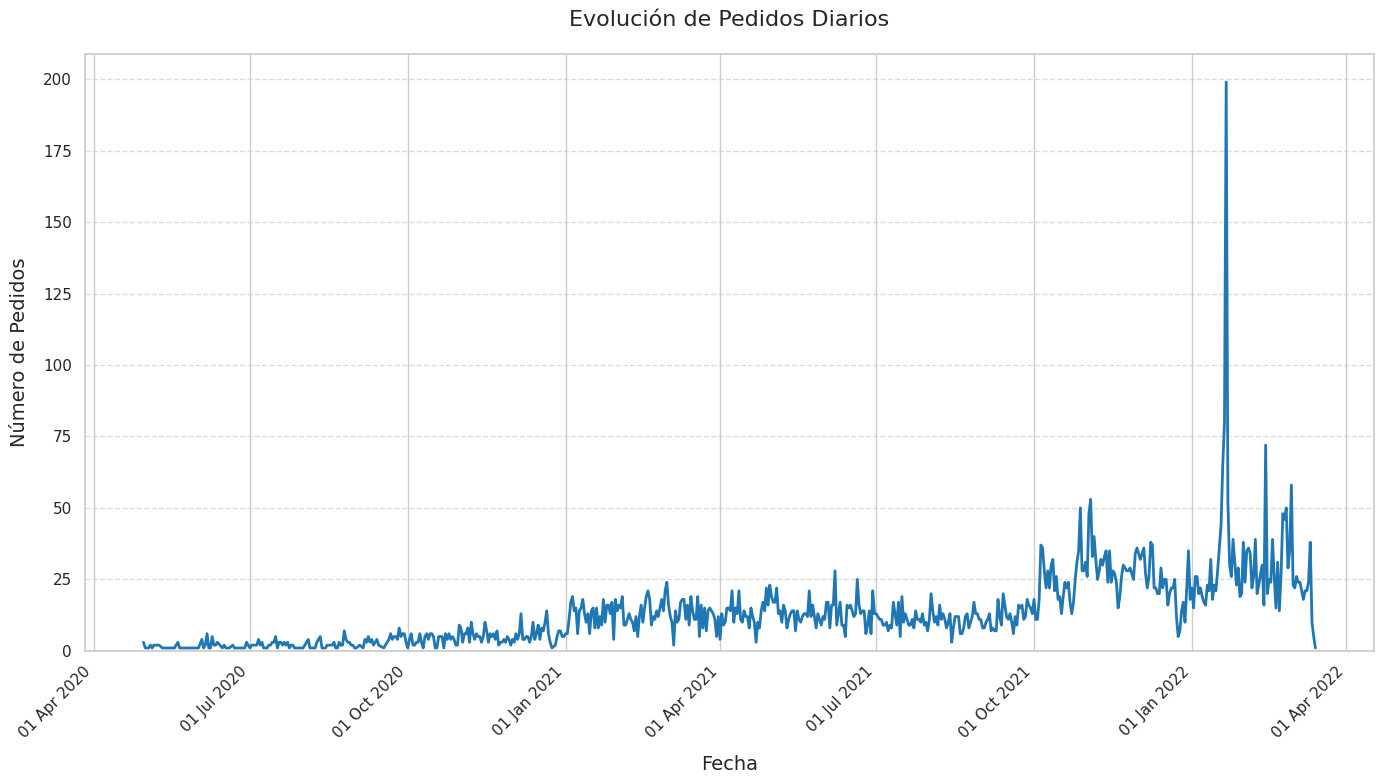

Total de pedidos: 8773
Promedio por dai: 13.4 pedidos
Periodo con más pedidos: 21-01-2022 (199 pedidos)
Periodo con menos pedidos: 01-05-2020 (1 pedidos)


/tmp/ipykernel_8568/3750207296.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='day_of_week', y='avg_per_day', data=weekday_pattern, palette='viridis')


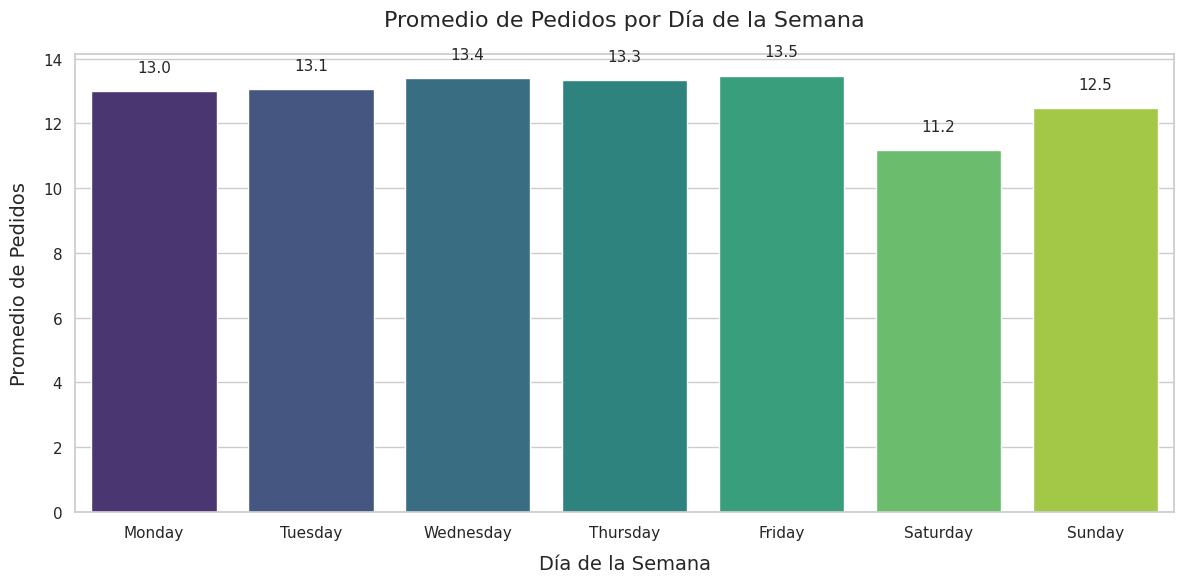


Día de la semana con más pedidos: Friday (13.5 promedio)
Día de la semana con menos pedidos: Saturday (11.2 promedio)


{'total_orders': 8773,
 'avg_orders_per_period': 13.434915773353753,
 'max_orders': 199,
 'min_orders': 1,
 'max_period': Timestamp('2022-01-21 00:00:00'),
 'min_period': Timestamp('2020-05-01 00:00:00'),
 'weekday_pattern': {'Monday': 12.995607613469986,
  'Tuesday': 13.067349926793558,
  'Wednesday': 13.395314787701318,
  'Thursday': 13.333821376281113,
  'Friday': 13.477306002928257,
  'Saturday': 11.171303074670572,
  'Sunday': 12.472913616398243},
 'max_weekday': 'Friday',
 'min_weekday': 'Saturday'}

In [208]:
plot_orders_time_series(
    orders_df,
    date_column='order_date',
    aggregation='daily',
    rolling_window=3,
    show_trend=False,
    show_weekday_chart=True,
    show_summary_stats=True,
    figsize=(14, 8),
    title_prefix='Evolución de Pedidos',
    color='#1f77b4',
    trend_color='red',
    save_fig=False
)

Cantidades de items en los pedidos y en los carritos abandonados



=== DISTRIBUCIÓN DE ÍTEMS EN PEDIDOS ===



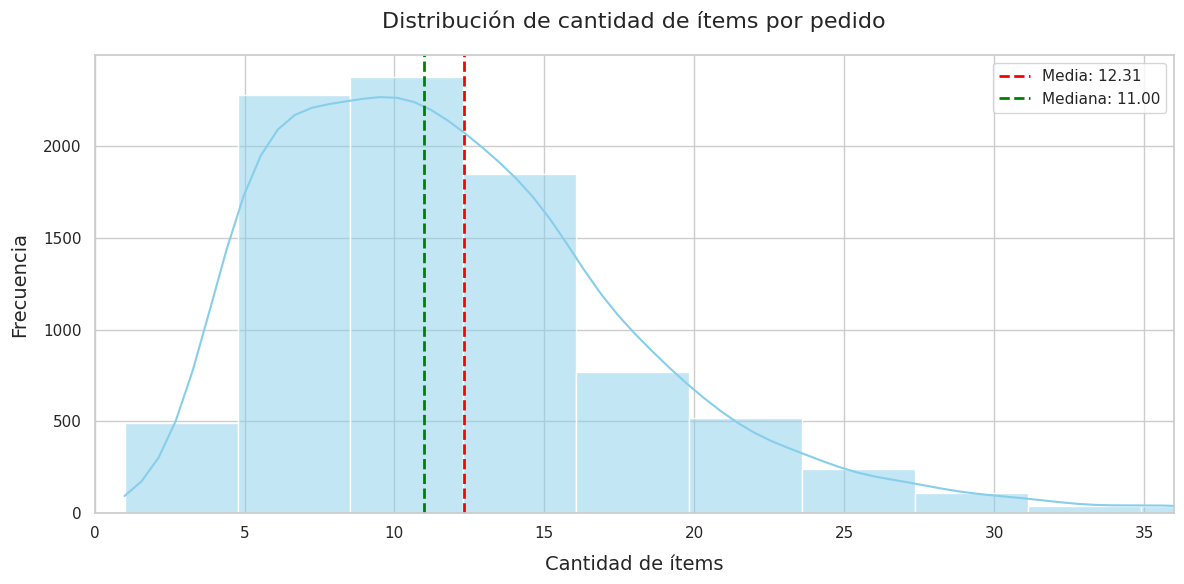

Estadísticas de cantidad de ítems:
Media: 12.31
Mediana: 11.00
Mínimo: 1
Máximo: 114
Desviación estándar: 6.84

Cantidades más frecuentes de ítems:
1 ítems: 6 veces (0.1%)
2 ítems: 54 veces (0.6%)
3 ítems: 82 veces (0.9%)
4 ítems: 349 veces (4.0%)
5 ítems: 510 veces (5.8%)
6 ítems: 591 veces (6.7%)
7 ítems: 591 veces (6.7%)
8 ítems: 589 veces (6.7%)
9 ítems: 599 veces (6.8%)
10 ítems: 617 veces (7.0%)
11 ítems: 600 veces (6.8%)
12 ítems: 561 veces (6.4%)
13 ítems: 532 veces (6.1%)
14 ítems: 485 veces (5.5%)
15 ítems: 461 veces (5.3%)

=== DISTRIBUCIÓN DE ÍTEMS EN CARRITOS ABANDONADOS ===



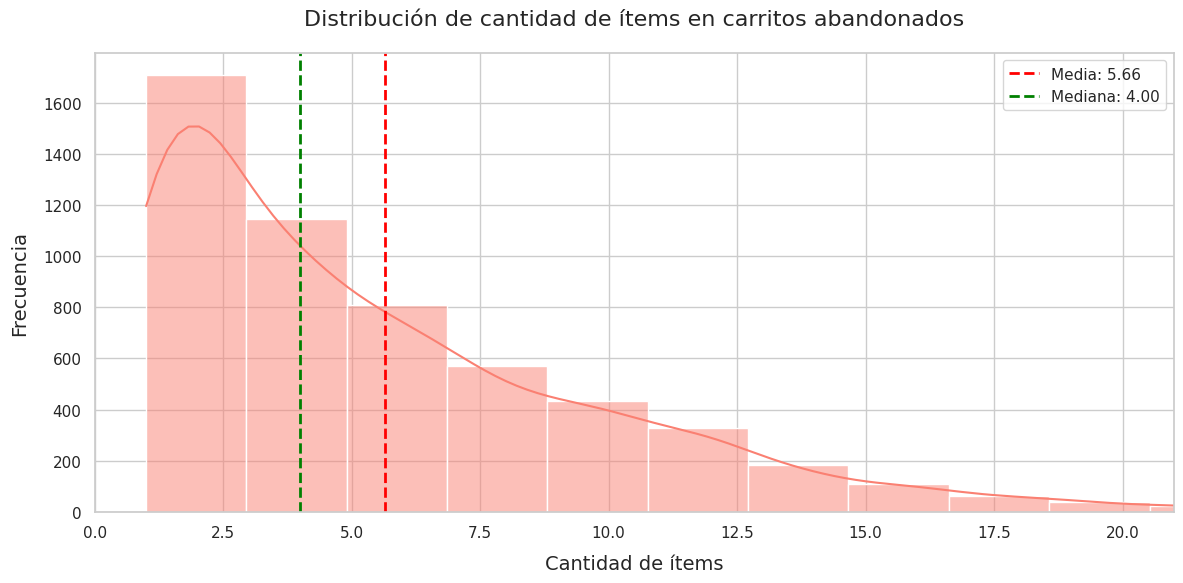

Estadísticas de cantidad de ítems:
Media: 5.66
Mediana: 4.00
Mínimo: 1
Máximo: 42
Desviación estándar: 4.72

Cantidades más frecuentes de ítems:
1 ítems: 814 veces (14.9%)
2 ítems: 895 veces (16.4%)
3 ítems: 611 veces (11.2%)
4 ítems: 533 veces (9.8%)
5 ítems: 427 veces (7.8%)
6 ítems: 383 veces (7.0%)
7 ítems: 322 veces (5.9%)
8 ítems: 247 veces (4.5%)
9 ítems: 223 veces (4.1%)
10 ítems: 211 veces (3.9%)
11 ítems: 166 veces (3.0%)
12 ítems: 161 veces (3.0%)
13 ítems: 105 veces (1.9%)
14 ítems: 79 veces (1.4%)
15 ítems: 54 veces (1.0%)


In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Optional, Tuple

# Configuramos el estilo de las visualizaciones
sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_items_distribution(
    df: pd.DataFrame, 
    items_column: str,
    title: str = 'Distribución de cantidad de ítems',
    color: str = 'skyblue',
    figsize: Tuple[int, int] = (12, 6),
    max_items: Optional[int] = None
) -> None:
    """
    Visualiza la distribución de la cantidad de ítems en cada registro.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame que contiene los datos
    items_column : str
        Nombre de la columna que contiene las listas de ítems
    title : str
        Título del gráfico
    color : str
        Color para las barras
    figsize : tuple
        Tamaño de la figura
    max_items : int, opcional
        Número máximo de ítems a mostrar en el eje X
    """
    # Crear una serie con la longitud de cada lista de ítems
    if df[items_column].dtype == 'object':
        # Si es una columna de tipo objeto, puede contener listas o representaciones string de listas
        item_counts = []
        for items in df[items_column]:
            if isinstance(items, list):
                item_counts.append(len(items))
            else:
                try:
                    # Intentar evaluar si es una representación string de una lista
                    items_list = eval(items)
                    item_counts.append(len(items_list))
                except:
                    # Si no se puede evaluar, asumir que es un solo ítem
                    item_counts.append(1)
    else:
        # Si no es de tipo objeto, asumir que cada fila es un ítem
        item_counts = [1] * len(df)
    
    # Convertir a DataFrame para facilitar el plotting
    counts_df = pd.DataFrame({'item_count': item_counts})
    
    # Calcular estadísticas
    stats = counts_df['item_count'].describe()
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=figsize)
    
    # Determinar límites para el histograma
    if max_items is None:
        # Usar el 99% percentil para evitar outliers extremos
        max_items = int(np.percentile(item_counts, 99))
    
    # Crear el histograma
    sns.histplot(
        data=counts_df, 
        x='item_count',
        bins=min(30, max_items), 
        kde=True,
        color=color,
        ax=ax
    )
    
    # Añadir una línea vertical en la media
    plt.axvline(
        x=stats['mean'], 
        color='red', 
        linestyle='--', 
        linewidth=2,
        label=f'Media: {stats["mean"]:.2f}'
    )
    
    # Añadir una línea vertical en la mediana
    plt.axvline(
        x=stats['50%'], 
        color='green', 
        linestyle='--', 
        linewidth=2,
        label=f'Mediana: {stats["50%"]:.2f}'
    )
    
    # Configurar el gráfico
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Cantidad de ítems', fontsize=14, labelpad=10)
    plt.ylabel('Frecuencia', fontsize=14, labelpad=10)
    plt.legend()
    
    # Limitar el eje X si se especifica
    if max_items:
        plt.xlim(0, max_items)
    
    # Ajustar márgenes
    plt.tight_layout()
    
    # Mostrar gráfico
    plt.show()
    
    # Mostrar estadísticas detalladas
    print(f"Estadísticas de cantidad de ítems:")
    print(f"Media: {stats['mean']:.2f}")
    print(f"Mediana: {stats['50%']:.2f}")
    print(f"Mínimo: {stats['min']:.0f}")
    print(f"Máximo: {stats['max']:.0f}")
    print(f"Desviación estándar: {stats['std']:.2f}")
    
    # Mostrar tabla de frecuencias para los valores más comunes
    value_counts = pd.Series(item_counts).value_counts().sort_index().head(15)
    print("\nCantidades más frecuentes de ítems:")
    for count, freq in value_counts.items():
        print(f"{count} ítems: {freq} veces ({freq/len(item_counts)*100:.1f}%)")

# Ejemplos de uso

# Para pedidos
print("\n=== DISTRIBUCIÓN DE ÍTEMS EN PEDIDOS ===\n")
plot_items_distribution(
    orders_df,
    'ordered_items',  # Ajusta esto al nombre correcto de tu columna
    title='Distribución de cantidad de ítems por pedido',
    color='skyblue'
)

# Para carritos abandonados
print("\n=== DISTRIBUCIÓN DE ÍTEMS EN CARRITOS ABANDONADOS ===\n")
plot_items_distribution(
    abandoned_carts_df,
    'variant_id',  # Ajusta esto al nombre correcto de tu columna
    title='Distribución de cantidad de ítems en carritos abandonados',
    color='salmon'
)